In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from datetime import datetime, timedelta
from pandas.tseries.holiday import USFederalHolidayCalendar

from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.preprocessing import normalize, minmax_scale
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from scipy.stats import skew
from scipy import stats
from sklearn.model_selection import cross_val_score, train_test_split


### Load data provided by PJM 
From: https://www.pjm.com/-/media/library/reports-notices/special-reports/2018/2018-emissions-report.ashx?la=en 

In [2]:
calc = pd.read_csv("pjm-mefs.csv")

### Updated Regression with More Data

In [3]:
# Label the df with the year, month, hour, and season 
def label_year_month(df):
    df = df.copy()
    df['year'] = df.index.year
    df['month'] = df.index.month
    return df

In [4]:
# Load ISO/RTO data, focus on PJM 
isorto_data1 = pd.read_csv("../data/formatted_data/cems_isorto.csv", index_col=0, parse_dates=[0])

isorto_data1 = isorto_data1.loc[isorto_data1['isorto'] == 'PJM']
isorto_data1 = label_year_month(isorto_data1)

In [5]:
# Group by year and month
data = isorto_data1.copy()
data = data.groupby(['year', 'month']).sum()
data = data.reset_index()

# Get MEF from PJM then find the MEF from the last hour
df = pd.merge(data, calc, how='left', on=['year', 'month'])
df['prev_co2_mef'] = df.mef.shift(1)
df = df.dropna()
df = df.drop_duplicates(subset=['year', 'month'], keep='first')
df = df[['year', 'month', 'co2_kg', 'so2_kg', 'nox_kg', 'pm25_kg', 'gload_mwh', 'prev_co2_mef', 'mef']]
df['gload_mwh'] = df['gload_mwh'].abs()

df.head()

,year,month,co2_kg,so2_kg,nox_kg,pm25_kg,gload_mwh,prev_co2_mef,mef
97,2014,2,3.561988e+10,8.398652e+07,3.472216e+07,5.023754e+06,46326701.94,1194.0,1212.0
98,2014,3,3.629593e+10,8.307979e+07,3.421347e+07,5.014618e+06,47451238.04,1212.0,1187.0
99,2014,4,2.838108e+10,6.188533e+07,2.648181e+07,3.863330e+06,36436451.24,1187.0,1088.0
100,2014,5,2.771748e+10,5.290305e+07,2.433106e+07,3.680962e+06,37329309.76,1088.0,1049.0
101,2014,6,3.405126e+10,6.677364e+07,2.805294e+07,4.467686e+06,44531938.01,1049.0,1116.0


In [6]:
# sin / cosine correction for month 
df['cos_month'] = np.cos((df.month)*(2*np.pi/12))
df['sin_month'] = np.sin((df.month)*(2*np.pi/12))

### Visualize Data

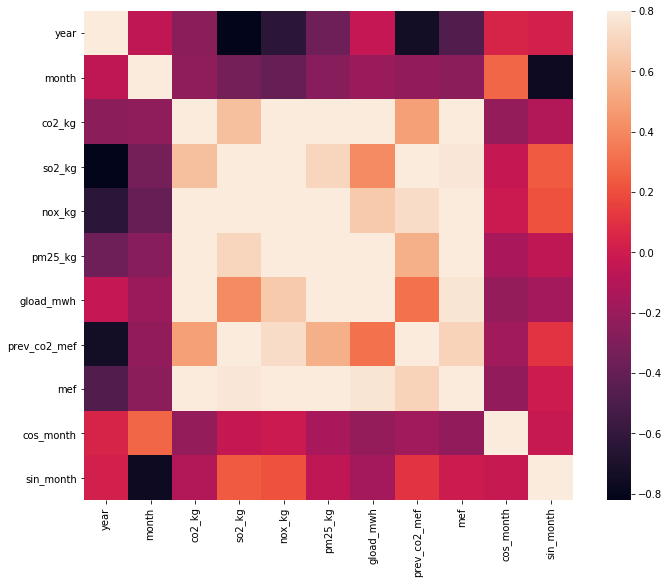

In [10]:
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)

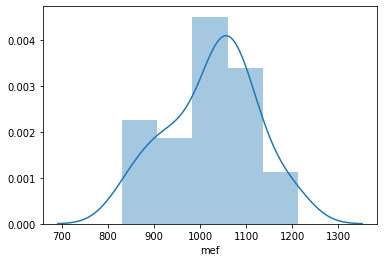

In [28]:
sns.distplot(df['mef'])

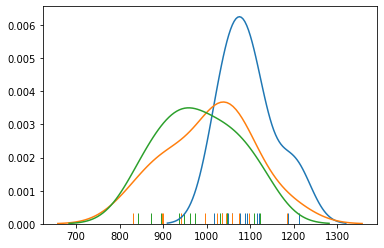

In [29]:
df_2012 = df.loc[df['year'] == 2014]
df_2013 = df.loc[df['year'] == 2015]
df_2014 = df.loc[df['year'] == 2016]

sns.distplot(df_2012[['mef']], hist=False, rug=True)
sns.distplot(df_2013[['mef']], hist=False, rug=True)
sns.distplot(df_2014[['mef']], hist=False, rug=True)

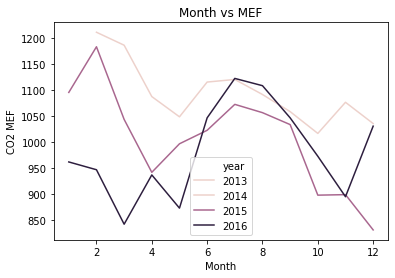

In [21]:
sns.lineplot(x="month", y="mef", hue="year", data=df)

plt.title("Month vs MEF")
plt.xlabel('Month')
plt.ylabel('CO2 MEF')


plt.show()

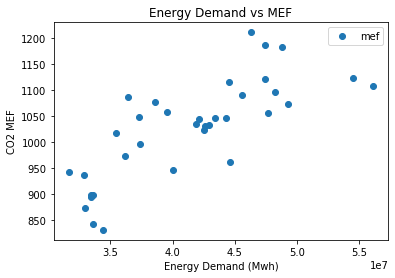

In [22]:
df.plot(x='gload_mwh', y='mef', style='o')  
plt.title('Energy Demand vs MEF')  
plt.xlabel('Energy Demand (Mwh)')
plt.ylabel('CO2 MEF')

plt.show()

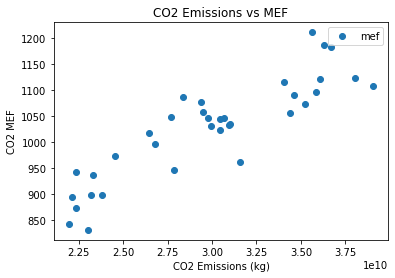

In [25]:
df.plot(x='co2_kg', y='mef', style='o')  
plt.title('CO2 Emissions vs MEF')  
plt.xlabel('CO2 Emissions (kg)')
plt.ylabel('CO2 MEF')

plt.show()

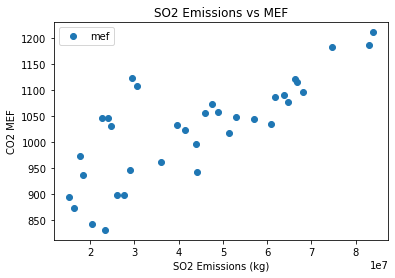

In [26]:
df.plot(x='so2_kg', y='mef', style='o')  
plt.title('SO2 Emissions vs MEF')  
plt.xlabel('SO2 Emissions (kg)')
plt.ylabel('CO2 MEF')

plt.show()

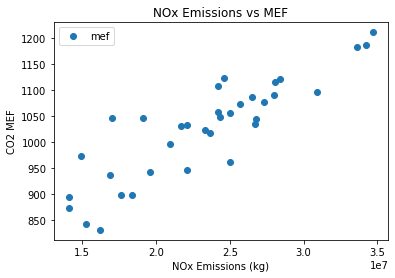

In [27]:
df.plot(x='nox_kg', y='mef', style='o')  
plt.title('NOx Emissions vs MEF')  
plt.xlabel('NOx Emissions (kg)')
plt.ylabel('CO2 MEF')
m
plt.show()

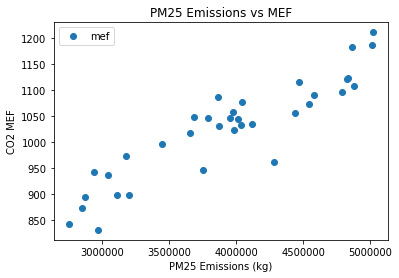

In [75]:
df.plot(x='pm25_kg', y='mef', style='o')  
plt.title('PM25 Emissions vs MEF')  
plt.xlabel('PM25 Emissions (kg)')
plt.ylabel('CO2 MEF')

plt.show()

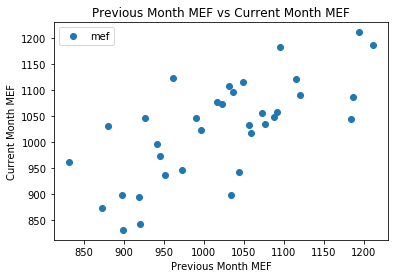

In [77]:
df.plot(x='prev_co2_mef', y='mef', style='o')  
plt.title('Previous Month MEF vs Current Month MEF')  
plt.xlabel('Previous Month MEF')
plt.ylabel('Current Month MEF')

plt.show()

### Implement Linear Regression

In [32]:
# Start with CO2 Calculations
x = df[['year', 'month', 'co2_kg', 'so2_kg', 'nox_kg', 'pm25_kg', 'gload_mwh', 'prev_co2_mef']]
y = df[['year', 'mef']]

X_train = x[(x['year']==2014) | (x['year'] == 2015)]
X_test = x.loc[x['year'] == 2016]

y_train = y[(y['year']==2014) | (y['year'] == 2015)]
y_test = y.loc[y['year'] == 2016]

y_train = y_train[['mef']]
y_test = y_test[['mef']]

lr = LinearRegression(normalize=True)
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [18]:
X_train = x[(x['year']==0) | (x['year'] == 0.5)]
X_test = x.loc[x['year'] == 1]

y_train = y[(y['year']==0) | (y['year'] == 0.5)]
y_test = y.loc[y['year'] == 1]

y_train = y_train[['mef']]
y_test = y_test[['mef']]

lr = LinearRegression(normalize=True)
lr.fit(X_train, y_train)

ValueError: Found array with 0 sample(s) (shape=(0, 9)) while a minimum of 1 is required.

In [9]:
lr.coef_

array([[ 1.46551573e-16,  0.00000000e+00, -1.44872701e-15,
         1.70654526e-16,  5.54610377e-16,  8.71526237e-16,
         1.00392261e-15,  1.33305396e-16,  1.00000000e+00]])

In [25]:
y_train

,mef
97,1212.0
98,1187.0
99,1088.0
100,1049.0
101,1116.0
102,1121.0
103,1092.0
104,1059.0
105,1017.0
106,1077.0


In [27]:
lr.score(X_train, y_train)

1.0

,year,month,co2_kg,so2_kg,nox_kg,pm25_kg,gload_mwh,prev_co2_mef,mef,cos_month,sin_month
97,2014,2,3.561988e+10,8.398652e+07,3.472216e+07,5.023754e+06,46326701.94,1194.0,1212.0,5.000000e-01,8.660254e-01
98,2014,3,3.629593e+10,8.307979e+07,3.421347e+07,5.014618e+06,47451238.04,1212.0,1187.0,6.123234e-17,1.000000e+00
99,2014,4,2.838108e+10,6.188533e+07,2.648181e+07,3.863330e+06,36436451.24,1187.0,1088.0,-5.000000e-01,8.660254e-01
100,2014,5,2.771748e+10,5.290305e+07,2.433106e+07,3.680962e+06,37329309.76,1088.0,1049.0,-8.660254e-01,5.000000e-01
101,2014,6,3.405126e+10,6.677364e+07,2.805294e+07,4.467686e+06,44531938.01,1049.0,1116.0,-1.000000e+00,1.224647e-16
102,2014,7,3.607296e+10,6.626605e+07,2.837105e+07,4.824710e+06,47441385.66,1116.0,1121.0,-8.660254e-01,-5.000000e-01
103,2014,8,3.460566e+10,6.386327e+07,2.803069e+07,4.580569e+06,45616538.13,1121.0,1092.0,-5.000000e-01,-8.660254e-01
104,2014,9,2.947112e+10,4.889465e+07,2.420502e+07,3.979012e+06,39549631.32,1092.0,1059.0,-1.836970e-16,-1.000000e+00
105,2014,10,2.648196e+10,5.134713e+07,2.363227e+07,3.651777e+06,35419041.87,1059.0,1017.0,5.000000e-01,-8.660254e-01
106,2014,11,2.935621e+10,6.463431e+07,2.735167e+07,4.040927e+06,38609729.78,1017.0,1077.0,8.660254e-01,-5.000000e-01


In [33]:
y_test

,mef
120,962.0
122,947.0
124,842.0
126,937.0
128,873.0
130,1047.0
132,1123.0
134,1109.0
136,1047.0
138,973.0


In [35]:
# Make predictions using the testing set
results = pd.DataFrame(index = X_test.index)
results['mef_predicted'] = lr.predict(X_test)
results['mef_actual'] = y_test['mef']
results.index = range(12)

# Calculate error: sum of (y - y(hat)) / y(hat)^2 
temp = pd.DataFrame()
temp['diff'] = abs(results['mef_actual'] - results['mef_predicted'])
temp['error'] = temp['diff'] / (results['mef_actual'])
print("Test error: " + str(temp['error'].mean()))

Test error: 0.06186119339107801


In [34]:
lr.predict(X_test)

array([[1039.54342381],
       [ 985.49901762],
       [ 859.37401101],
       [ 928.49983508],
       [ 871.5001401 ],
       [ 959.81874705],
       [1040.19771331],
       [1035.21823845],
       [ 920.749083  ],
       [ 869.36409079],
       [ 832.94015822],
       [ 959.15617108]])

In [21]:
results

,mef_predicted,mef_actual
0,962.0,962.0
1,947.0,947.0
2,842.0,842.0
3,937.0,937.0
4,873.0,873.0
5,1047.0,1047.0
6,1123.0,1123.0
7,1109.0,1109.0
8,1047.0,1047.0
9,973.0,973.0


In [36]:
# Training error 
train = pd.DataFrame(index = X_train.index)
train['mef_predicted'] = lr.predict(X_train)
train['mef_actual'] = y_train['mef']
train['diff'] = abs(train['mef_actual'] - train['mef_predicted'])
train['error'] = train['diff'] / (train['mef_actual'])
print("Training error: " + str(train['error'].mean()))

Training error: 0.014514647303015483


### Univariate Regression
Results of this paper: https://pubs.acs.org/doi/10.1021/acs.est.8b06586

In [19]:
# Start with CO2 Calculations
x_uni = df[['year', 'co2_kg','sin_month', 'so2_kg', 'pm25_kg', 'gload_mwh']]
y_uni = df[['year', 'mef']]

X_uni_train = x_uni[(x_uni['year']==2014) | (x_uni['year'] == 2015)]
X_uni_test = x_uni.loc[x_uni['year'] == 2016]

y_uni_train = y_uni[(y_uni['year']==2014) | (y_uni['year'] == 2015)]
y_uni_test = y_uni.loc[y_uni['year'] == 2016]

y_uni_train = y_uni_train[['mef']]
y_uni_test = y_uni_test[['mef']]
X_uni_train = X_uni_train[['year','sin_month', 'so2_kg']]
X_uni_test = X_uni_test[['year','sin_month', 'so2_kg']]

lr = LinearRegression(normalize=True)
lr.fit(X_uni_train, y_uni_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [20]:
# Make predictions using the testing set
results['mef_univariate'] = lr.predict(X_uni_test)
results.index = range(12)

# Calculate error: sum of (y - y(hat)) / y(hat)^2 
temp = pd.DataFrame()
temp['diff'] = abs(results['mef_actual'] - results['mef_univariate'])
temp['error'] = temp['diff'] / (results['mef_actual'])
print("Test error: " + str(temp['error'].mean()))

Test error: 0.07827155089459241


In [21]:
# Training error 
train = pd.DataFrame(index = X_uni_train.index)
train['mef_predicted'] = lr.predict(X_uni_train)
train['mef_actual'] = y_train['mef']
train['diff'] = abs(train['mef_actual'] - train['mef_predicted'])
train['error'] = train['diff'] / (train['mef_actual'])
print("Training error: " + str(train['error'].mean()))

Training error: 0.02320202901966953


### Lasso

In [79]:
x = df[['year', 'month', 'co2_kg', 'so2_kg', 'nox_kg', 'pm25_kg', 'gload_mwh', 'prev_co2_mef']]
y = df[['year', 'mef']]



In [78]:
X_train

,year,month,co2_kg,so2_kg,nox_kg,pm25_kg,gload_mwh,prev_co2_mef


In [80]:
X_train = x[(x['year']==2014) | (x['year'] == 2015)]
X_test = x.loc[x['year'] == 2016]

y_train = y[(y['year']==2014) | (y['year'] == 2015)]
y_test = y.loc[y['year'] == 2016]

y_train = y_train[['mef']]
y_test = y_test[['mef']]

X_train = (X_train-X_train.min())/(X_train.max()-X_train.min())
y_train = (y_train-y_train.min())/(y_train.max()-y_train.min())

In [100]:
from sklearn.metrics import mean_squared_error

# final one
reg = Lasso(alpha=0.0001, max_iter=10e5)
reg.fit(X_train,y_train)

#test = pd.DataFrame(index = X_train.index)
#test['mef_predicted'] = lr.predict(X_test)

print("test " + str(mean_squared_error(y_test,reg.predict(X_test))))
print("train " + str(mean_squared_error(y_train,reg.predict(X_train))))

test 4.038215837979669e+20
train 0.002371191353182269


test 4731.377244072949
train 337.16117062391413


In [19]:
reg.coef_

array([-0.,  0., -0.,  0.,  0.,  0.])

In [31]:
reg.predict(X_test)

array([1007.34392808,  970.90529439,  857.71876849,  952.23737699,
        891.70647941,  978.30089935, 1046.21693949, 1049.14474184,
        944.87224932,  887.15357503,  845.44833176,  977.80146619])

In [53]:
# Make predictions using the testing set
results['mef_lasso'] = reg.predict(X_test)
#results.index = range(12)

In [54]:
results

,mef_predicted,mef_actual,mef_univariate,mef_lasso
0,1007.444051,962.0,968.594385,1004.696100
1,971.003911,947.0,913.929397,948.057533
2,857.782497,842.0,854.918396,829.206970
3,952.437035,937.0,845.709879,925.264163
4,891.854263,873.0,842.998082,872.393808
5,978.398563,1047.0,906.963847,967.130045
6,1046.254558,1123.0,956.694784,1044.752581
7,1049.153361,1109.0,974.347057,1049.724600
8,944.933357,1047.0,927.877813,946.909111
9,887.242219,973.0,891.593290,889.330129


In [55]:
# Calculate error: sum of (y - y(hat)) / y(hat)^2 
temp = pd.DataFrame()
temp['diff'] = abs(results['mef_actual'] - results['mef_lasso'])
temp['error'] = temp['diff'] / (results['mef_actual'])
print("Test error: " + str(temp['error'].mean()))

Test error: 0.04698496413113592


In [56]:
# Training error 
train = pd.DataFrame(index = X_train.index)
train['mef_predicted'] = reg.predict(X_train)
train['mef_actual'] = y_train['mef']
train['diff'] = abs(train['mef_actual'] - train['mef_predicted'])
train['error'] = train['diff'] / (train['mef_actual'])
print("Training error: " + str(train['error'].mean()))

Training error: 0.01988071418166161


In [257]:
lasso.coef_

array([ 0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  5.39970353e-08,
       -3.12326736e-05,  0.00000000e+00])

In [258]:
coef

cos_month      -0.125686
sin_month      -0.040899
year           -0.020776
co2_kg          0.000000
so2_kg          0.000000
gload_mwh       0.000000
prev_co2_mef    0.000829
pm25_kg         0.015301
nox_kg          0.826848
dtype: float64

Text(0.5, 1.0, 'Coefficients in the Model')

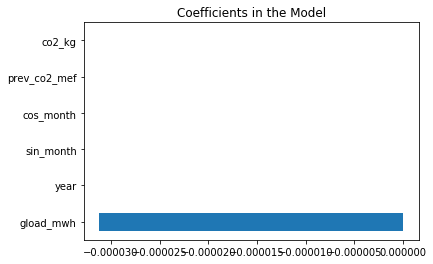

In [259]:
imp_coef = pd.DataFrame()
coef = pd.Series(lasso.coef_, index = X_train.columns).sort_values()
imp_coef = pd.concat([coef.head(10)])
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Model")

In [261]:
# Make predictions using the testing set
results_lasso = pd.DataFrame(index = X_test.index)
results_lasso['mef_predicted'] = lasso.predict(X_test)
results_lasso['mef_actual'] = y['mef']

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [98]:
# Calculate error: sum of (y - y(hat)) / y(hat) 
# Test data 
results_lasso['diff'] = abs(results_lasso['mef_actual'] - results_lasso['mef_predicted'])
results_lasso['error'] = results_lasso['diff'] / (results_lasso['mef_actual'])
print("Test error: " + str(results_lasso['error'].mean()))

Test error: 0.06173776413465069


In [ ]:
# Training data 
train = pd.DataFrame(index = X_train.index)
train['mef_predicted'] = lr.predict(X_train)
train['mef_actual'] = y_train['mef']
train['diff'] = abs(train['mef_actual'] - train['mef_predicted'])
train['error'] = train['diff'] / (train['mef_actual'])
print("Training error: " + str(train['error'].mean()))

In [58]:
df_compare = pd.read_csv("mef-regression.csv", index_col=0)
df_compare = df_compare.loc[df_compare['pollutant'] == 'co2']

df_compare = df_compare[['year', 'month']]
df_compare = df_compare[df_compare['year'].isin(['2016'])]

df_compare.columns = ['year', 'month']
df_compare.index = range(12)

In [59]:
df_compare = df_compare.join(results)
df_compare

,year,month,mef_predicted,mef_actual,mef_univariate,mef_lasso
0,2016,1,1007.444051,962.0,968.594385,1004.696100
1,2016,2,971.003911,947.0,913.929397,948.057533
2,2016,3,857.782497,842.0,854.918396,829.206970
3,2016,4,952.437035,937.0,845.709879,925.264163
4,2016,5,891.854263,873.0,842.998082,872.393808
5,2016,6,978.398563,1047.0,906.963847,967.130045
6,2016,7,1046.254558,1123.0,956.694784,1044.752581
7,2016,8,1049.153361,1109.0,974.347057,1049.724600
8,2016,9,944.933357,1047.0,927.877813,946.909111
9,2016,10,887.242219,973.0,891.593290,889.330129


In [60]:
df_graph = df_compare.melt(id_vars=["year", "month"], 
        var_name="Type", 
        value_name="mef")

df_graph['date'] = df_graph["year"].astype(str) + "-" + df_graph["month"].astype(str)
df_graph['date'] = pd.to_datetime(df_graph['date'])

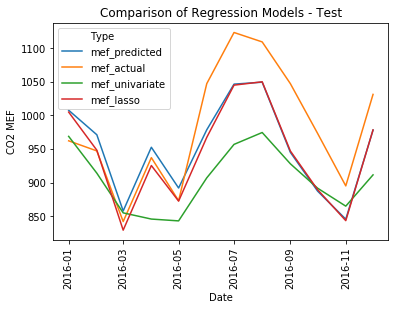

In [63]:
sns.lineplot(x='date', y="mef", hue="Type", data=df_graph)

plt.title("Comparison of Regression Models - Test")
plt.xlabel('Date')
plt.ylabel('CO2 MEF')
_=plt.xticks(rotation=90)  
plt.show()

# Archive

In [31]:
from sklearn.metrics import make_scorer, mean_squared_error

def rmse_cv(model, X, y):
     return (cross_val_score(model, X, y, scoring=scorer)).mean()

    # scorer = make_scorer(rmsle, False)
scorer = make_scorer(mean_squared_error, False)

In [59]:
from sklearn.model_selection import GridSearchCV

# find optimal alpha with grid search
alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid = dict(alpha=alpha)
grid = GridSearchCV(estimator=reg, param_grid=param_grid, scoring='r2', verbose=1, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Best Score:  0.9999981059266305
Best Params:  {'alpha': 0.001}


[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    1.6s finished


In [276]:
from sklearn.metrics import mean_squared_error

lambdas = (0.001, 0.01, 0.1, 0.5, 1, 2, 10, 100)
l_num = 8
pred_num = X.shape[1]

# prepare data for enumerate
coeff_a = np.zeros((l_num, pred_num))
mse_train = np.zeros(l_num)
mse_test = np.zeros(l_num)

In [277]:
# enumerate through lambdas with index and i
for ind, i in enumerate(lambdas):    
    reg = Lasso(alpha = i)
    reg.fit(X_train, y_train)

    coeff_a[ind,:] = reg.coef_
    train_r_squared[ind] = mean_squared_error(mef, y_train)
    test_r_squared[ind] = reg.score(X_test, y_test)

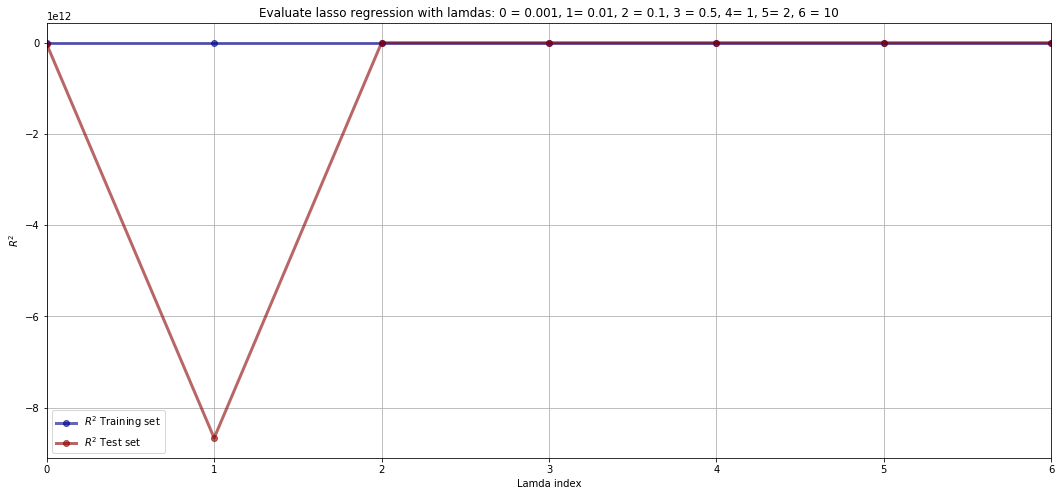

In [278]:
# Plotting
plt.figure(figsize=(18, 8))
plt.plot(train_r_squared, 'bo-', label=r'$R^2$ Training set', color="darkblue", alpha=0.6, linewidth=3)
plt.plot(test_r_squared, 'bo-', label=r'$R^2$ Test set', color="darkred", alpha=0.6, linewidth=3)
plt.xlabel('Lamda index'); plt.ylabel(r'$R^2$')
plt.xlim(0, 6)
plt.title(r'Evaluate lasso regression with lamdas: 0 = 0.001, 1= 0.01, 2 = 0.1, 3 = 0.5, 4= 1, 5= 2, 6 = 10')
plt.legend(loc='best')
plt.grid()